# Imports

In [6]:
!pip install lifelines

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd
import random
# import scipy.stats as ss

import h5py
import missingno
import seaborn as sns

from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import StratifiedShuffleSplit
from lifelines import KaplanMeierFitter

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


ModuleNotFoundError: No module named 'lifelines'

# Predictive maintenance

In [8]:
filename: str = "/kaggle/input/predictive-maintenance-dataset/Dataset_2.1.csv"
data = pd.read_csv(filename, sep=',')
data.head()

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py", line 223, in catch_format_error
    r = method(self, *args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/formatters.py", line 344, in __call__
    return method()
  File "/opt/conda/lib/python3.10/site-packages/pandas/core/frame.py", line 1106, in _repr_html_
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/format.py", line 1110, in to_html
    When formatting an Index subclass
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/html.py", line 88, in to_string
    lines = self.render()
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/html.py", line 644, in render
    super().render()
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/html.py", line 94, in render
    self._write_table()
  File "/opt/conda/lib/python3.10/site-packages/pandas/io/formats/html.py", line 267, in _write_table
  

   Unnamed: 0  usage  Temperature     Pression  censored  \
0           0  False    14.975284  1000.695430     False   
1           1  False    16.857807   992.757881     False   
2           2  False    18.565954  1002.509288     False   
3           3   True    14.681768   994.701873     False   
4           4  False    16.365552   995.131057     False   

  event (fail or censored)  
0          374.96963956347  
1       336.45767926983166  
2       268.89438720990216  
3        59.60865767745483  
4         573.565608383586  

estimation k: 1.0756203289115371 estimation lambda: 5405.37646218178


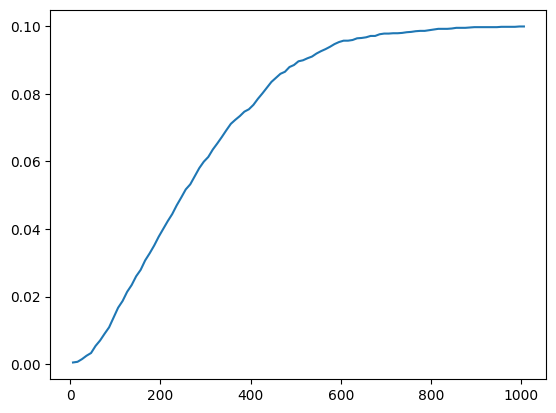

In [9]:
# First method :
# We perform a parametric estimation by Weibull distribution.
n_sample=1000
equipement_life = np.sort(data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]).astype(float)
t = np.arange(1, 1020, 10)
f, v = np.histogram(equipement_life, t)

F = np.cumsum(f)
F = F / 10000
plt.plot((v[0:-1]+v[1:])/2, F)
logt = np.log((t[0:-1]+t[1:])/2)
loglogF = np.log(-np.log(1-F))

lr = LinearRegression()
logt = logt[~np.isinf(loglogF)]
loglogF = loglogF[~np.isinf(loglogF)]
lr.fit(logt.reshape(-1, 1), loglogF.reshape(-1, 1))

k_hat = lr.coef_[0][0]
lambda_hat = np.exp(lr.intercept_/(-k_hat))[0]

print('estimation k:', k_hat, 'estimation lambda:', lambda_hat)

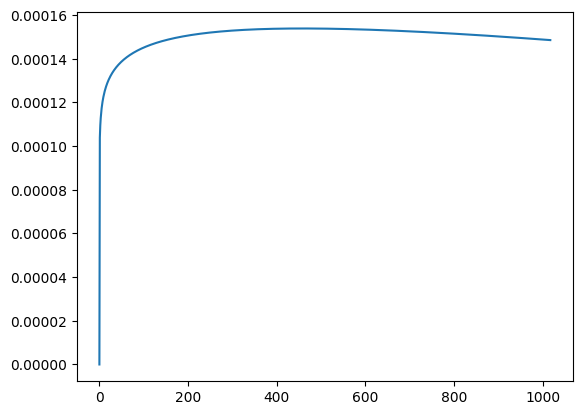

In [10]:
d = np.arange(0, np.max(equipement_life))
survival = (k_hat/lambda_hat) * np.power((d/lambda_hat),(k_hat-1))*np.exp(-np.power((d/lambda_hat), k_hat))
plt.plot(d, survival)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_35/2480106649.py", line 17, in <module>
    kmf.survival_function_.plot(ax=plt.gca())
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 920, in __call__
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1886, in _get_plot_backend
    if hasattr(eps, "select"):
  File "/opt/conda/lib/python3.10/site-packages/pandas/plotting/_core.py", line 1817, in _load_backend
    >>> ax = df.plot.hexbin(x='x', y='y', gridsize=20)
ImportError: matplotlib is required for plotting when the default backend "matplotlib" is selected.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2102, in s

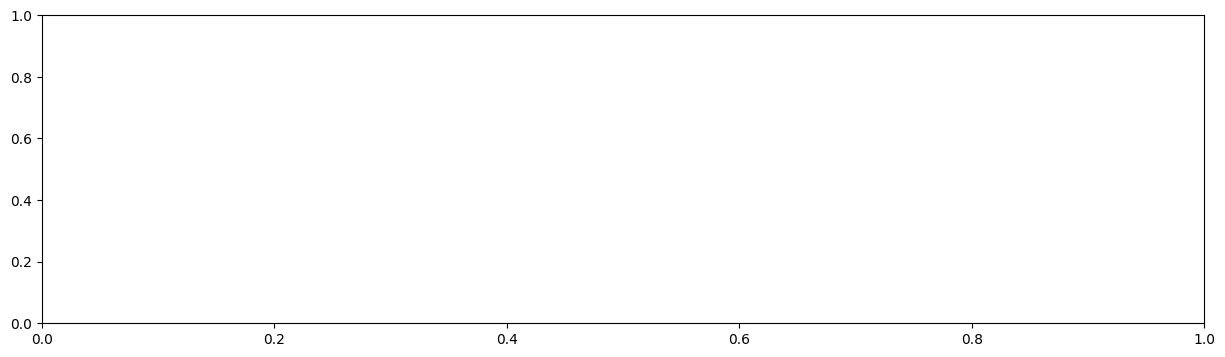

In [11]:
n_sample=1000

#Kaplan Meier
durations=data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]
event_observed=data.loc[data['censored'] == False, 'usage'].to_list()[0:n_sample]
durations = np.array(durations).astype(float)
event_observed = np.array(event_observed)

# Kaplan Meier estimation
kmf = KaplanMeierFitter()

# Fitting
kmf.fit(durations, event_observed)

# Displaying the survival function and confidence intervals
fig, ax = plt.subplots(figsize=(15,4))
kmf.survival_function_.plot(ax=plt.gca())
ax.set_title("Kaplan-Meier Survival function", fontsize=20)

confidence_interval = kmf.confidence_interval_survival_function_
time_steps = confidence_interval.index
low, high = np.transpose(confidence_interval.values)
ax.fill_between(time_steps, low, high, color="gray", alpha=0.3)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax.set_ylabel("S(t) Survival function")
ax.set_xlabel("Time")
ax.legend(["Kaplan-Meier Survival function", "Confidence Interval"])
plt.show()

In [ ]:
# 1) Corrective maintainance
limit_time = 365*3
equipement_life = np.sort(data.loc[data['censored'] == False, 'event (fail or censored)'].to_list()[0:n_sample]).astype(float)
cost_samples = np.zeros(1000)
for simulation in range(1000):
    cost = 0
    limite = limit_time
    tirage = random.choice(equipement_life)
    while tirage < limite:
        cost += 1000
        limite -= tirage
        tirage = random.choice(equipement_life)
    cost_samples[simulation] = cost

print(np.mean(cost_samples))

In [ ]:
# 2) Preventive maintenance
period_to_be_tested = np.arange(1, 365*3-1, 50)
nb_sample = 1000
period_cost = np.zeros(len(period_to_be_tested))
for idp, period in enumerate(period_to_be_tested):
    cost_samples = np.zeros(nb_sample)
    for simulation in range(nb_sample):
        cost = 0
        age = 0
        # Each maintenance is planned
        for planed_maintenance in range(0, 365*3-1, period):
            # sample life of equipement after planned maintenance
            tirage = random.choice(equipement_life)
            limite = period
            # If equipement lives not long enough, there is corrective maintenance (only if age is young enough)
            if tirage < limite :
                age += tirage
            else: # else, we move to next planned maintenance
                age += period
            
            while (tirage < limite) and (age < 365*3):
                cost += 1000 
                limite -= tirage # the limit is reduced because multiple failure can occur
                tirage = random.choice(equipement_life)
                age += tirage
            cost += 100
        cost_samples[simulation] = cost
    period_cost[idp] = np.mean(cost_samples)
print(period_cost)
print("Best period:", period_to_be_tested[np.argmin(period_cost)])
print("Best cost:", period_cost[np.argmin(period_cost)])

In [ ]:
# 3) Predictive maintenance
nb_sample = 1000
cost_samples = np.zeros(nb_sample)
for simulation in range(nb_sample):
    cost = 0
    limite = 365*3
    tirage = random.choice(equipement_life)
    age = tirage
    while (tirage < limite) and age < 365*3:
        if np.random.rand() > 0.8:
            cost += 1000
        else:
            cost += 100
        limite -= tirage
        tirage = random.choice(equipement_life)
        age += tirage
    cost_samples[simulation] = cost
print(np.mean(cost_samples)+1)

The minimum cost is realised with predictive maintenance

In [ ]:
filename = "/kaggle/input/predictive-maintenance-dataset/Dataset_3.2.h5"

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W = np.array(hdf.get('W'))             # W
        X_s = np.array(hdf.get('X_s'))         # X_s
        X_v = np.array(hdf.get('X_v'))         # X_v
        T = np.array(hdf.get('T'))             # T
        Y = np.array(hdf.get('Y'))             # RUL  
        A = np.array(hdf.get('A'))             # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))

        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))

Number of cycles for which the motor is sent to maintenance

In [ ]:
df_A = pd.DataFrame(data=A, columns=A_var)
print(df_A.describe())
print('Engine units IDs in dataframe: ', np.unique(df_A['unit']))
# Votre code
df_failures = pd.DataFrame()

fail = []
for i in np.unique(df_A['unit']):
    print('Unit: ' + str(i) + ' - Number of flight cyles (t_{EOF}): ', len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))
    fail.append(len(np.unique(df_A.loc[df_A['unit'] == i, 'cycle'])))

df_failures['unit'] = np.unique(df_A['unit'])
df_failures['fail'] = fail

plt.plot(df_failures['fail'], np.ones(df_failures.shape[0]), '+')
plt.xlim(0, 120)

In [ ]:
df_T = pd.DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
df_T.describe()

first = True
for u in df_A['unit'].unique():
    if first:
        df_tmp = df_T.loc[df_A['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_A['unit']==u]
        ax = df_tmp.plot(subplots=True, figsize=(20, 10))
        first = False
    else:
        df_tmp = df_T.loc[df_A['unit']==u]
        df_tmp.index = df_T['cycle'].loc[df_A['unit']==u]
        df_tmp.plot(subplots=True, figsize=(20, 10), ax= ax)

In [ ]:
# Sensors dataframe
df_X_s = pd.DataFrame(data=X_s, columns=X_s_var) 
df_X_v = pd.DataFrame(data=X_v, columns=X_v_var) 

We use StratifiedShuffleSplit for train / validation / test split of the dataframe

In [ ]:
ssf = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

## Data cleaning and selection

The three types of possible missing data are :

* Completely Random Missing Data (MCAR)
* Random Missing Data (MAR)
* Deterministic Missing Data (MNAR)

In [ ]:
filename = "/kaggle/input/predictive-maintenance-dataset/Dataset_4.1.h5"

# Load data
with h5py.File(filename, 'r') as hdf:
        # Development set
        W = np.array(hdf.get('W'))             # W
        X_s = np.array(hdf.get('X_s'))         # X_s
        X_v = np.array(hdf.get('X_v'))         # X_v
        T = np.array(hdf.get('T'))             # T
        Y = np.array(hdf.get('Y'))             # RUL  
        A = np.array(hdf.get('A'))             # Auxiliary
        
        # Varnams
        W_var = np.array(hdf.get('W_var'))
        X_s_var = np.array(hdf.get('X_s_var'))  
        X_v_var = np.array(hdf.get('X_v_var')) 
        T_var = np.array(hdf.get('T_var'))
        A_var = np.array(hdf.get('A_var'))

        # from np.array to list dtype U4/U5
        W_var = list(np.array(W_var, dtype='U20'))
        X_s_var = list(np.array(X_s_var, dtype='U20'))  
        X_v_var = list(np.array(X_v_var, dtype='U20')) 
        T_var = list(np.array(T_var, dtype='U20'))
        A_var = list(np.array(A_var, dtype='U20'))
    
df_A = pd.DataFrame(data=A, columns=A_var)
print(df_A.describe())
print('Engine units IDs in the dataframe: ', np.unique(df_A['unit']))
df_T = pd.DataFrame(data=T, columns=T_var) 
df_T['unit'] = df_A['unit'].values
df_T['cycle'] = df_A['cycle'].values
# Dataframe of sensors
df_X_s = pd.DataFrame(data=X_s, columns=X_s_var) 
df_X_v = pd.DataFrame(data=X_v, columns=X_v_var)

Let visualise those data

In [ ]:
# First, we show values and types for each variable
for i in df_A.keys():
    print(df_A[i].iloc[0:3])

for j in df_T.keys():
    print(df_T[j].iloc[0:3])

for k in df_X_s.keys():
    print(df_X_s[k].iloc[0:3])

for l in df_X_v.keys():
    print(df_X_v[l].iloc[0:3])

In [ ]:
# We visualise the mean of data in the dataframe
print("df_A : ")
print(pd.DataFrame(df_A.isna().mean()),"\n")
print("df_T : ")
print(pd.DataFrame(df_T.isna().mean()),"\n")
print("df_X_s : ")
print(pd.DataFrame(df_X_s.isna().mean()),"\n")
print("df_X_v : ")
print(pd.DataFrame(df_X_v.isna().mean()),"\n")

In [ ]:
# We use missingno value
missingno.matrix(df_X_s)

In [ ]:
df_X_s_dropna= df_X_s.dropna()
print(len(df_X_s_dropna)/len(df_X_s))
# Removing missing data only remove 3% of the dataset

In [ ]:
myRIF = IsolationForest(n_estimators=500, contamination=0.1)
df_X_s_dropna.loc[:, "_isoutlier"] = myRIF.fit_predict(df_X_s_dropna)
df_X_v.loc[:, "_isoutlier"] = myRIF.fit_predict(df_X_v)

perc_1 = 100*(df_X_s_dropna.loc[:, "_isoutlier"]==-1).mean()
perc_2 = 100*(df_X_v.loc[:, "_isoutlier"]==-1).mean()
print(f"anomaly percent in senser X_s: {perc_1} %")
print(f"anomaly percent in senser X_v: {perc_2} %")

We obtain 10% of outliers in the dataset. Let's visualise them :

In [ ]:
for k in df_X_s_dropna.keys():
    sns.displot(data=df_X_s_dropna, x=k, hue="_isoutlier", kind="hist", bins=30, multiple="stack")

In [ ]:
for k in df_X_v.keys():
    sns.displot(data=df_X_v, x=k, hue='_isoutlier', kind='hist', bins=30, multiple="stack")